# Making the Vz Vb figure.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch.

In [2]:
gaia_mc = pd.read_csv("gaia_mc.csv")
print(np.shape(gaia_mc))

# Cut out visual binaries.
gaia_mc = gaia_mc.iloc[gaia_mc.flag.values == 1]
print(np.shape(gaia_mc), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc.vb_err.values < 1.
print(np.shape(gaia_mc.iloc[m]), "no large vb uncertainties")

m &= gaia_mc.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc.age.values > .5
print(np.shape(gaia_mc.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars
m &= (gaia_mc.color_teffs.values < 5000) * (3500 < gaia_mc.color_teffs.values)
print(np.shape(gaia_mc.iloc[m]), "no hot or cold stars")

gaia_mc = gaia_mc.iloc[m]

(29727, 156)
(10674, 156) no visual binaries or subgiants
(10533, 156) no large vb uncertainties
(10394, 156) no faint stars
(9791, 156) no rapid rotators
(6925, 156) no hot or cold stars


Load the GUMS catalogs

In [3]:
high_b = pd.read_csv("high_b.csv", skiprows=68, delimiter=";")
max_b = pd.read_csv("max_b.csv", skiprows=68, delimiter=";")
low_b = pd.read_csv("min_b.csv", skiprows=68, delimiter=";")
mid_b = pd.read_csv("mid_b.csv", skiprows=68, delimiter=";")

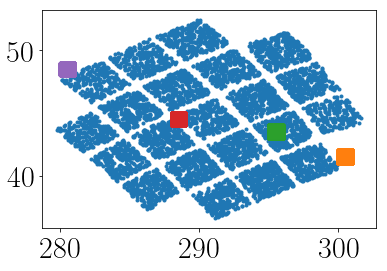

In [4]:
plt.plot(gaia_mc.ra, gaia_mc.dec, ".")
plt.plot(low_b.RAJ2000, low_b.DEJ2000, ".")
plt.plot(mid_b.RAJ2000, mid_b.DEJ2000, ".")
plt.plot(max_b.RAJ2000, max_b.DEJ2000, ".")
plt.plot(high_b.RAJ2000, high_b.DEJ2000, ".")

In [5]:
import astropy.coordinates as coord
import astropy.units as u

def calc_vb_vz(df):

    sim_c_minb = coord.SkyCoord(ra=df.RAJ2000.values*u.deg,
                            dec=df.DEJ2000.values*u.deg,
                            distance=df.r.values*u.pc,
                            pm_ra_cosdec=df.pmRA.values*u.mas/u.yr,
                            pm_dec=df.pmDE.values*u.mas/u.yr,
                            radial_velocity=df.RV.values*u.km/u.s)

    gal = sim_c_minb.galactic
    galcen = sim_c_minb.transform_to(coord.Galactocentric)
    l, b = gal.l.degree, gal.b.degree

    vb = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles())
    vz = galcen.v_z
    return vb, vz, l, b

def calc_lb(ra, dec):
    c = coord.SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    gal = c.galactic
    return gal.l.degree, gal.b.degree

Apply similar cuts to the GUMS catalogs.

In [6]:
m1 = (low_b.Gmag.values < 16) * (low_b.r.values < max(1./gaia_mc.parallax.values*1e3)) \
    * (low_b.Teff.values < 6000) * (low_b.Teff.values > 0)
df1 = low_b.iloc[m1]
vb1, vz1, l1, b1 = calc_vb_vz(df1)

m2 = (mid_b.Gmag.values < 16) * (mid_b.r.values < max(1./gaia_mc.parallax.values*1e3)) \
    * (mid_b.Teff.values < 6000) * (mid_b.Teff.values > 0)
df2 = mid_b.iloc[m2]
vb2, vz2, l2, b2 = calc_vb_vz(df2)

m3 = (max_b.Gmag.values < 16) * (max_b.r.values < max(1./gaia_mc.parallax.values*1e3)) \
    * (max_b.Teff.values < 6000) * (max_b.Teff.values > 0)
df3 = max_b.iloc[m3]
vb3, vz3, l3, b3 = calc_vb_vz(df3)

m4 = (high_b.Gmag.values < 16) * (high_b.r.values < max(1./gaia_mc.parallax.values*1e3)) \
    * (high_b.Teff.values < 6000) * (high_b.Teff.values > 0)
df4 = high_b.iloc[m4]
vb4, vz4, l4, b4 = calc_vb_vz(df4)

Plot velocities.

[0.98018351 4.45532089]


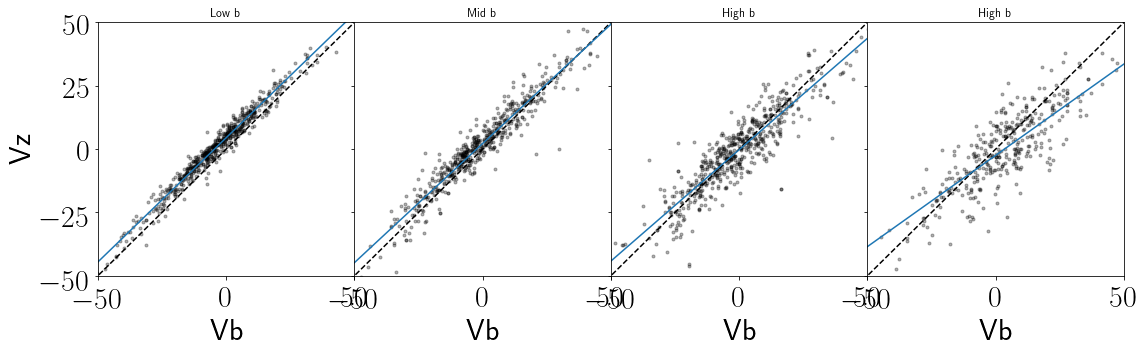

In [7]:
x = np.linspace(-100, 100, 100)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(141)

ax1.plot(x, x, "k--", zorder=0)
ax1.plot(vb1, vz1, "k.", alpha=.3)
p = np.polyfit(vb1, vz1, 1)
print(p)
ax1.plot(x, np.polyval(p, x))
ax1.set_xlabel("Vb")
ax1.set_ylabel("Vz")
ax1.set_xlim(-50, 50)
ax1.set_ylim(-50, 50)
plt.title("Low b")

ax2 = fig.add_subplot(142, sharey=ax1)
ax2.plot(x, x, "k--", zorder=0)
ax2.plot(vb2, vz2, "k.", alpha=.3)
p = np.polyfit(vb2, vz2, 1)
ax2.plot(x, np.polyval(p, x))
ax2.set_xlabel("Vb")
ax2.set_xlim(-50, 50)
plt.title("Mid b")
plt.setp(ax2.get_yticklabels(), visible=False)

ax3 = fig.add_subplot(143, sharey=ax1)
ax3.plot(x, x, "k--", zorder=0)
ax3.plot(vb3, vz3, "k.", alpha=.3)
p = np.polyfit(vb3, vz3, 1)
ax3.plot(x, np.polyval(p, x))
ax3.set_xlabel("Vb")
ax3.set_xlim(-50, 50)
plt.title("High b")
plt.setp(ax3.get_yticklabels(), visible=False)

ax4 = fig.add_subplot(144, sharey=ax1)
ax4.plot(x, x, "k--", zorder=0)
ax4.plot(vb4, vz4, "k.", alpha=.3)
p = np.polyfit(vb4, vz4, 1)
ax4.plot(x, np.polyval(p, x))
ax4.set_xlabel("Vb")
ax4.set_xlim(-50, 50)
ax4.set_ylim(-50, 50)
plt.title("High b")
plt.setp(ax4.get_yticklabels(), visible=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0)

In [8]:
def Gaussian(x, mu, sigma):
    return 1./(sigma*np.sqrt(2*np.pi)) * np.exp(-.5*(x - mu)**2/sigma**2)

def nll(pars, x, y):
    mu, sigma = pars
    model = Gaussian(x, mu, sigma)
    return sum(.5 * (y - model)**2)

0.4023218794028879 2.6131000145262546
0.5826533273898865 4.251602383593327
0.43622795501445644 6.5933489260272165
0.6848123811861392 9.182660014841531


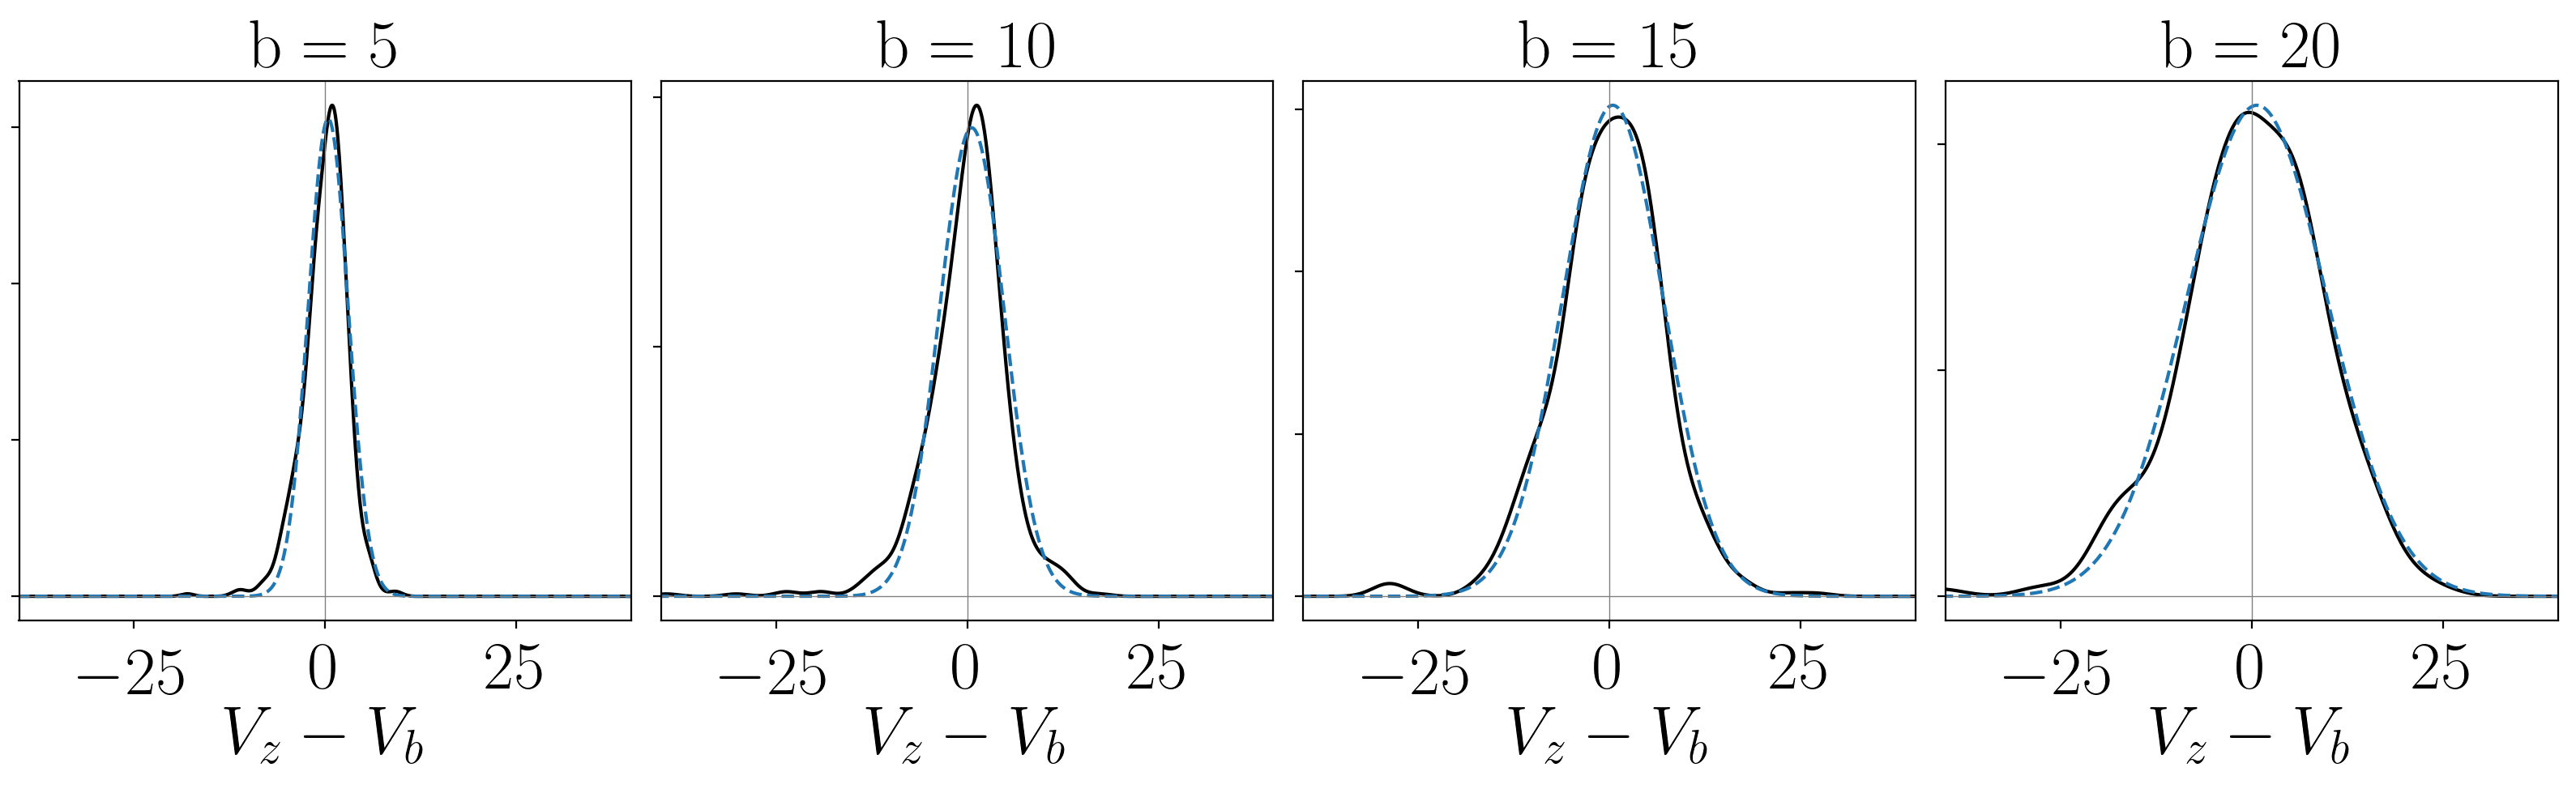

In [11]:
import scipy.stats as sps
import scipy.optimize as spo

fig = plt.figure(figsize=(16, 5), dpi=200)

def make_panel(vb1, vz1, title, ax):
    x = np.linspace(-50, 50, 1000)
    p = np.polyfit(vb1, vz1, 1)
    # plt.hist(vz1.value - np.polyval(p, vb1), 20, density=True);
    kernel = sps.gaussian_kde(vz1.value - np.polyval(p, vb1))
    ax.plot(x, kernel(x), "k")
    results = spo.minimize(nll, [0, 10], args=(x, kernel(x)))
    mu, sig = results.x
    print(mu, sig)
    ax.plot(x, Gaussian(x, mu, sig), color="C0", ls="--",
            label="$\mu = {0:.2f}, \sigma={1:.2f}$".format(mu, sig))
    ax.axvline(0, color=".5", lw=.5)
    ax.axhline(0, color=".5", lw=.5)
    ax.set_xlabel("$V_z-V_b$")
    ax.set_xlim(-40, 40)
    plt.title(title, fontsize=30)
#     plt.legend(bbox_to_anchor=(0., .0, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)

ax1 = fig.add_subplot(141)
make_panel(vb1, vz1, "$\mathrm{b=5}$", ax1)
# ax1.set_ylabel("$\mathrm{Probability}$")
plt.setp(ax1.get_yticklabels(), visible=False)

ax2 = fig.add_subplot(142)
make_panel(vb2, vz2, "$\mathrm{b=10}$", ax2)
plt.setp(ax2.get_yticklabels(), visible=False)

ax3 = fig.add_subplot(143)
make_panel(vb3, vz3, "$\mathrm{b=15}$", ax3)
plt.setp(ax3.get_yticklabels(), visible=False)

ax4 = fig.add_subplot(144)
make_panel(vb4, vz4, "$\mathrm{b=20}$", ax4)
plt.setp(ax4.get_yticklabels(), visible=False)

plt.subplots_adjust(wspace=0)
plt.tight_layout()
plt.savefig("vb_vz")
plt.savefig("vb_vz.pdf")
plt.savefig("paper/vb_vz.pdf")

slope =  0.44100853086759423 intercept =  0.14757119890215578


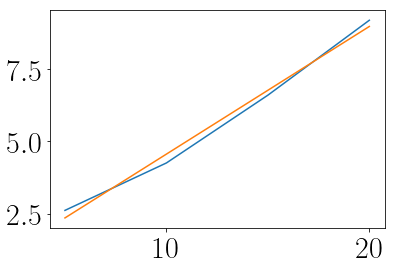

In [23]:
sigmas = np.array([2.6131000145262546, 4.251602383593327, 6.5933489260272165, 9.182660014841531])
bs = np.array([5, 10, 15, 20])
plt.plot(bs, sigmas)
p = np.polyfit(bs, sigmas, 1)
xs = np.linspace(5, 20, 100)
plt.plot(xs, p[1] + p[0]*xs)
print("slope = ", p[0], "intercept = ", p[1])